In [ ]:
%%capture
%pip install networkx --upgrade
%pip install pandas --upgrade
%pip install scipy --upgrade

In [ ]:

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import scipy as sc

# Combining Data to make a stops-to-station correlation

In [ ]:
# Load data into a Pandas DataFrame
df_s = pd.read_csv("mta_subway_stations_data.csv")

# import package for buffering distance between stops
from geopy import distance

# Initialize a counter for the station ID
station_id = 0

# Sort stops by name
df_s = df_s.sort_values(by=['stop_name']).reset_index(drop=True)

# generate station_id for new instances while keeping old station_id for closeby stops
for index, row in df_s.iterrows():
    if index == 0: 
      df_s.loc[index, "station_id"] = str(station_id) + '-' + df_s.loc[index, "stop_name"]
      continue

    if df_s.iloc[index]['stop_name'] == df_s.iloc[index-1]['stop_name']:
        if distance.distance((df_s.iloc[index]["lat"], df_s.iloc[index]["lon"]), (df_s.iloc[index-1]["lat"], df_s.iloc[index-1]["lon"])).miles < 0.1:
            df_s.loc[index, "station_id"] = str(station_id) + '-' +  df_s.loc[index, "stop_name"]
        else:
            station_id += 1
            df_s.loc[index, "station_id"] = str(station_id) + '-' +  df_s.loc[index, "stop_name"]
    else:
        station_id += 1
        df_s.loc[index, "station_id"] = str(station_id) + '-' +  df_s.loc[index, "stop_name"]

In [ ]:
df_s # This data is saved as stops_with_stations.csv for further querying

,index,stop_id,stop_name,lat,lon,station_id
0,0,L06,1 Av,40.730953,-73.981628,0-1 Av
1,1,624,103 St,40.790600,-73.947478,1-103 St
2,2,A18,103 St,40.796092,-73.961454,2-103 St
3,3,119,103 St,40.799446,-73.968379,3-103 St
4,4,706,103 St - Corona Plaza,40.749865,-73.862700,4-103 St - Corona Plaza
...,...,...,...,...,...,...
496,496,401,Woodlawn,40.886037,-73.878751,470-Woodlawn
497,497,712,Woodside - 61 St,40.745630,-73.902984,471-Woodside - 61 St
498,498,E01,World Trade Center,40.712582,-74.009781,472-World Trade Center
499,499,F18,York St,40.701397,-73.986751,473-York St


# Top code is used to generate node-and-edge table with the following code


In [ ]:
# SELECT *, ROUND(average_transit_time / total_count_of_from_and_to *1000, 2) AS transit_weight
# 	FROM(
# 		SELECT COUNT(from_stop_id) AS total_count_of_from_and_to,
# 				sfrom.station_id AS from_station,
# 				sto.station_id AS to_station,
# 				ROUND(AVG(transit_time), 2) AS average_transit_time
# 		FROM stops_and_transit_durations st
# 			INNER JOIN stops_with_stations sfrom
# 				ON sfrom.stop_id = st.from_stop_id
# 			INNER JOIN stops_with_stations sto
# 				ON sto.stop_id = st.to_stop_id
# 		GROUP BY sfrom.station_id, sto.station_id
# 	)

# Generate graph theory chart for stops (not stations)


In [245]:
df_ne

,total_count,Unnamed: 1,from_stop,to_stop,transit_weight
0,501,101,103,1.52,3.03
1,514,103,101,1.50,2.92
2,517,103,104,1.50,2.90
3,514,104,103,3.16,6.15
4,517,104,106,1.50,2.90
...,...,...,...,...,...
1092,330,S01,S03,2.00,6.06
1093,330,S03,S01,2.00,6.06
1094,330,S03,S04,1.50,4.55
1095,330,S04,D26,3.00,9.09


In [249]:
# Load data into a Pandas DataFrame
df_ne = pd.read_csv("mta_subway_stops_nodes_edges.csv")
df_s = pd.read_csv("mta_subway_stops_data.csv")

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add nodes to the graph
for stop in df_s["stop_id"].unique():
    G.add_node(stop, pos=(df_s[df_s["stop_id"] == stop]["stop_lon"].values[0], df_s[df_s["stop_id"] == stop]["stop_lat"].values[0]))

# Add nodes to the graph using the unique source and target nodes from the dataframe
G.add_nodes_from(df_ne['from_stop'].unique())
G.add_nodes_from(df_ne['to_stop'].unique())

# Iterate through the dataframe and add edges to the graph, with weights
for index, row in df_ne.iterrows():
    G.add_edge(row['from_stop'], row['to_stop'], weight=row['transit_weight'])

In [ ]:
nx.get_edge_attributes(G,'weight')

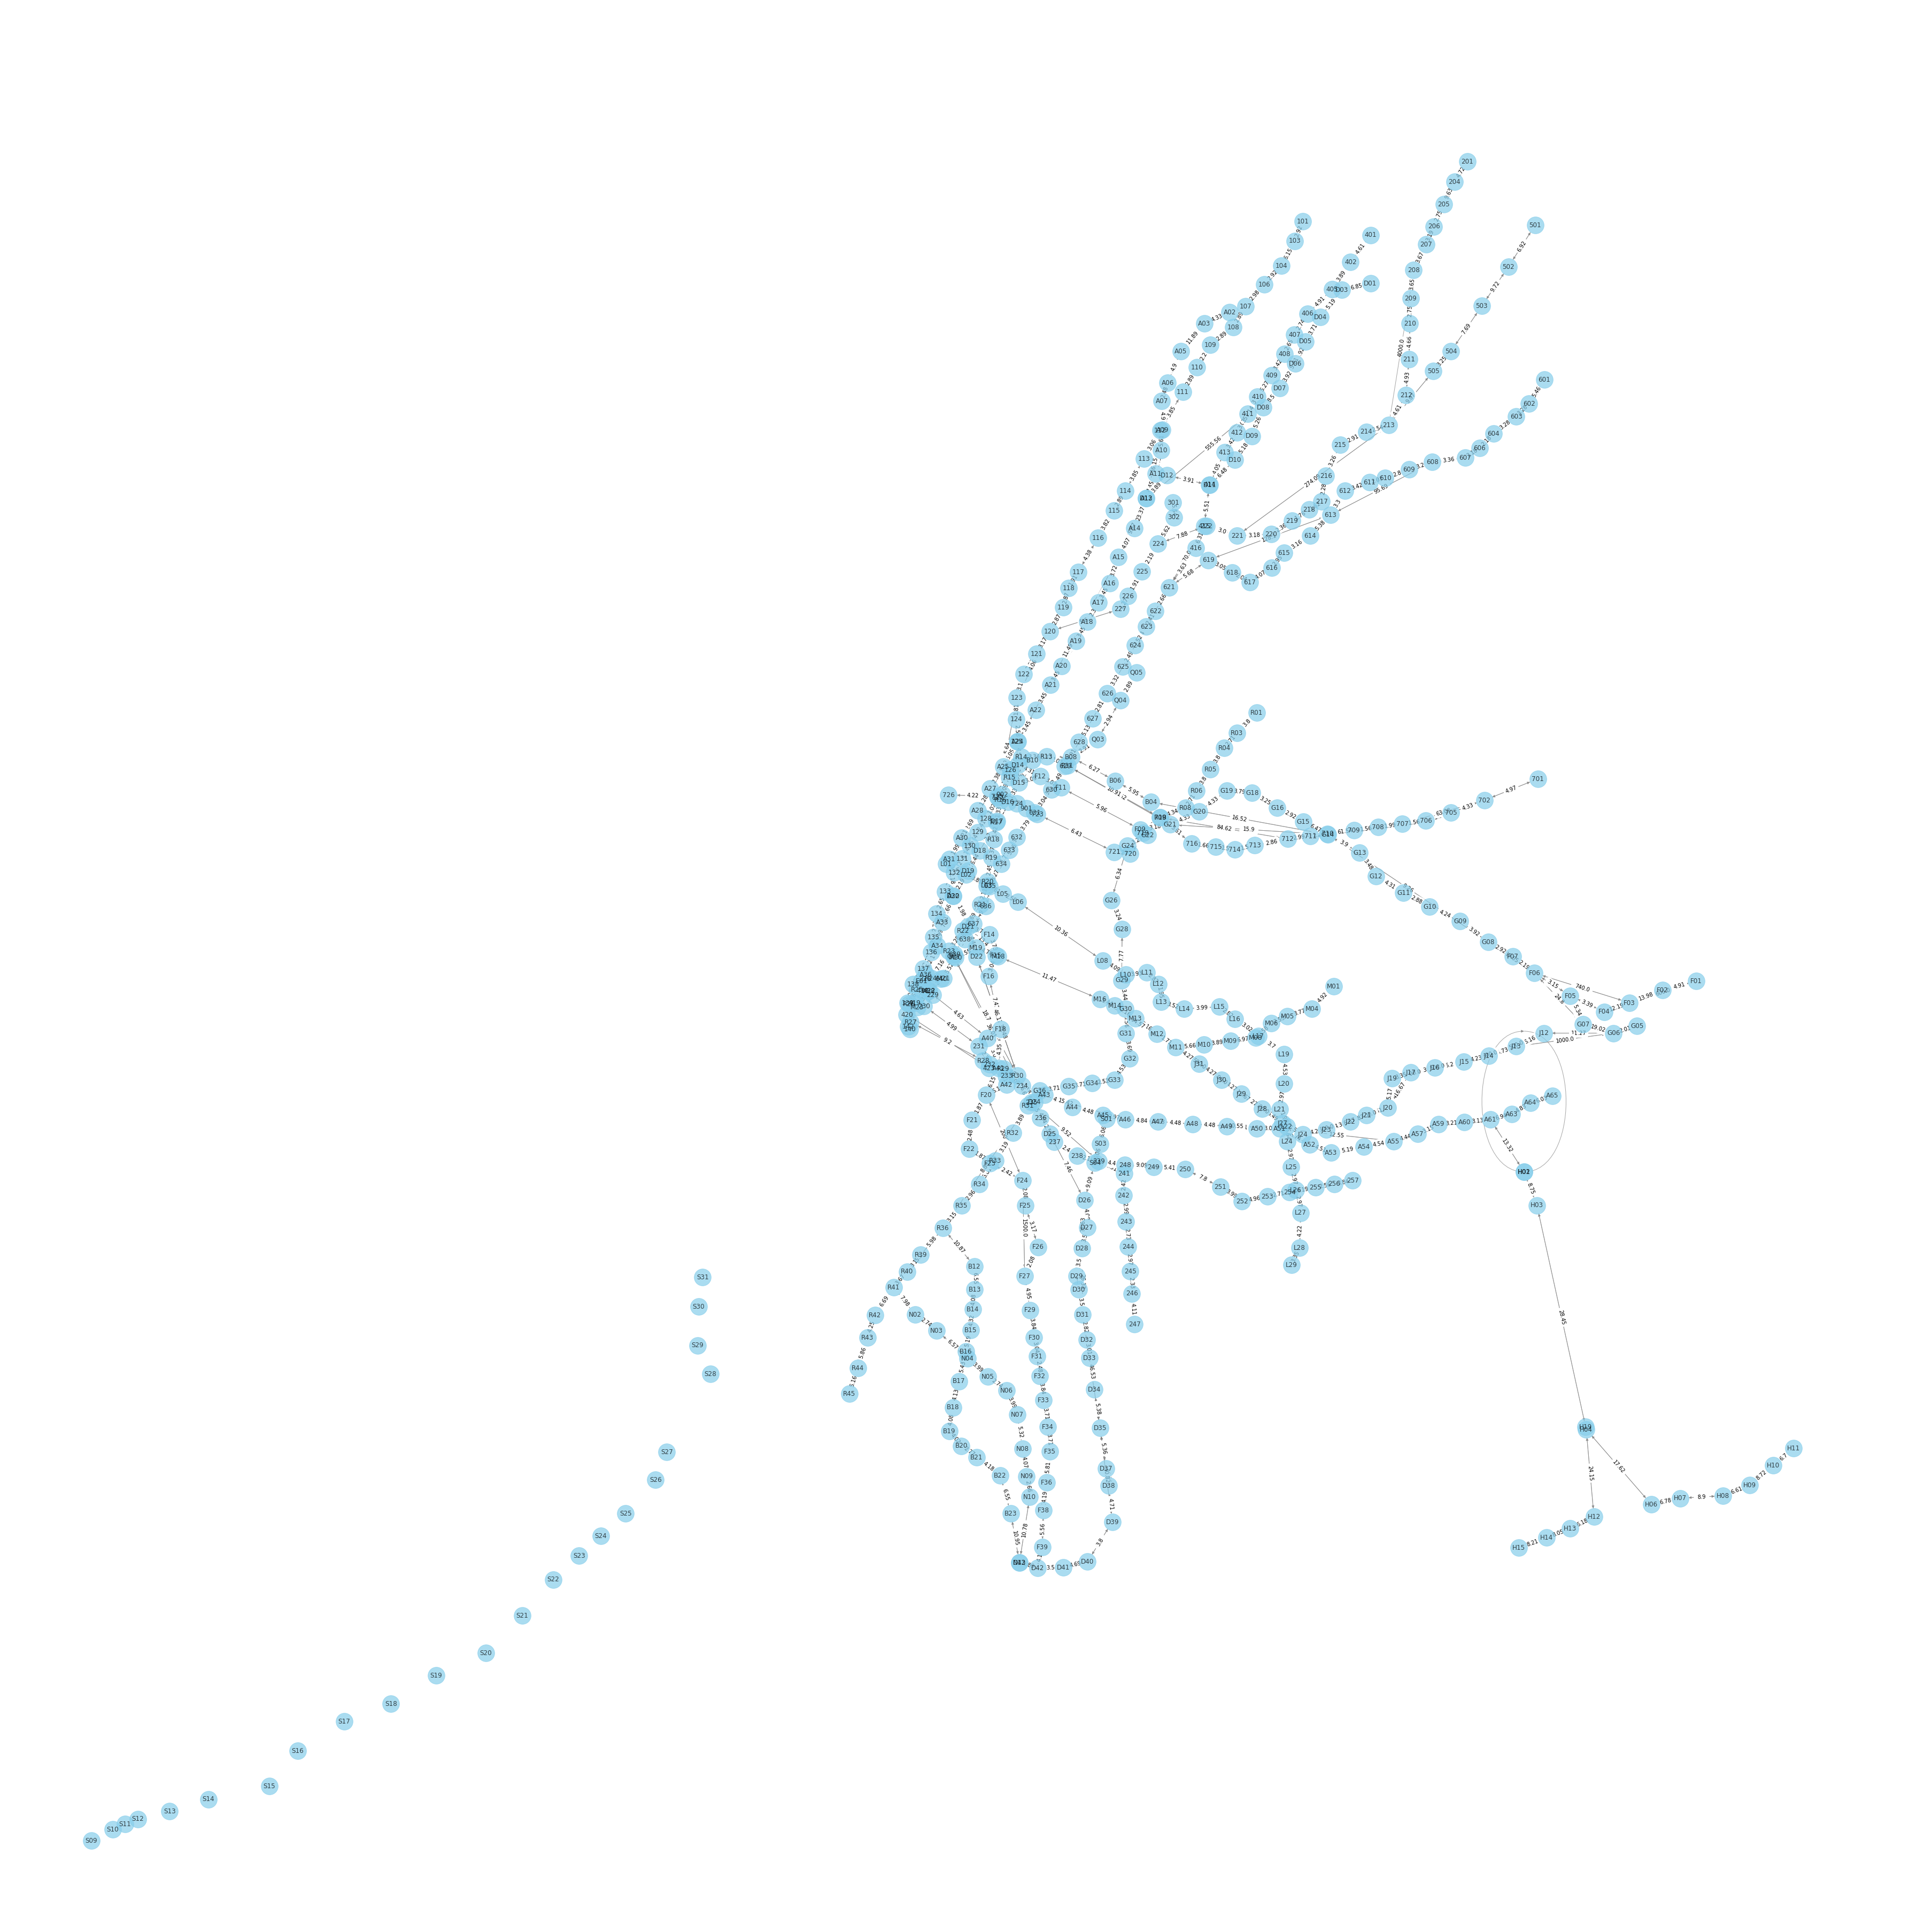

In [258]:
# nx.draw(G)

# Draw the graph using matplotlib
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(50,50)) 
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1000, alpha=0.7)
nx.draw_networkx_edge_labels(G, pos,
                        edge_labels=nx.get_edge_attributes(G,'weight'))
plt.show()

In [253]:
degrees = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
# eigs = nx.eigenvector_centrality(G)
df = pd.DataFrame([degrees,closeness,betweenness]).transpose()
df.columns = ['degrees','closeness','betweenness']
df

,degrees,closeness,betweenness
101,0.004,0.011989,0.000000
103,0.008,0.012475,0.001218
104,0.008,0.012994,0.002421
106,0.008,0.013551,0.003607
107,0.008,0.014149,0.004778
...,...,...,...
S27,0.000,0.000000,0.000000
S28,0.000,0.000000,0.000000
S29,0.000,0.000000,0.000000
S30,0.000,0.000000,0.000000


# Generate graph theory chart for Stations


In [269]:
# Load data into a Pandas DataFrame
df_ne = pd.read_csv("mta_subway_station_nodes_edges.csv")
df_s = pd.read_csv("mta_subway_stations_data.csv")

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add nodes to the graph
for station in df_s["station_id"].unique():
    # if station == '189-Bay Ridge - 95 St': print(station)
    G.add_node(station, pos=(df_s[df_s["station_id"] == station]["lon"].values[0], df_s[df_s["station_id"] == station]["lat"].values[0]))

# Add nodes to the graph using the unique source and target nodes from the dataframe
G.add_nodes_from(df_ne['station_from'].unique())
G.add_nodes_from(df_ne['station_to'].unique())

# Iterate through the dataframe and add edges to the graph, with weights
for index, row in df_ne.iterrows():
    G.add_edge(row['station_from'], row['station_to'], weight=row['transit_weight'])

In [270]:
# df_ne.head()
df_ne.query('station_from == "R45"')

,total_count,station_from,station_to,average_transit_time,transit_weight


In [271]:
df_s.query('station_id == "R45"')

,index,stop_id,stop_name,lat,lon,station_id


In [272]:
nx.get_edge_attributes(G,'weight')

{('0-1 Av', '202-Bedford Av'): 12.56,
 ('0-1 Av', '82-3 Av'): 2.59,
 ('1-103 St', '162-96 St'): 2.5,
 ('1-103 St', '7-110 St'): 1.74,
 ('2-103 St', '159-96 St'): 3.4,
 ('2-103 St', '237-Cathedral Pkwy (110 St)'): 2.3,
 ('3-103 St', '161-96 St'): 3.82,
 ('3-103 St', '236-Cathedral Pkwy'): 2.87,
 ('4-103 St - Corona Plaza', '342-Junction Blvd'): 1.48,
 ('4-103 St - Corona Plaza', '8-111 St'): 1.5,
 ('5-104 St', '15-121 St'): 500.0,
 ('5-104 St', '469-Woodhaven Blvd'): 4.29,
 ('5-104 St', '9-111 St'): 5.73,
 ('6-104 St', '10-111 St'): 6.5,
 ('6-104 St', '422-Rockaway Blvd'): 6.94,
 ('7-110 St', '1-103 St'): 1.7,
 ('7-110 St', '13-116 St'): 2.41,
 ('8-111 St', '366-Mets - Willets Point'): 4.33,
 ('8-111 St', '4-103 St - Corona Plaza'): 1.46,
 ('9-111 St', '15-121 St'): 5.16,
 ('9-111 St', '442-Sutphin Blvd - Archer Av - JFK Airport'): 1000.0,
 ('9-111 St', '469-Woodhaven Blvd'): 428.57,
 ('9-111 St', '5-104 St'): 5.81,
 ('10-111 St', '398-Ozone Park - Lefferts Blvd'): 4.44,
 ('10-111 St', 

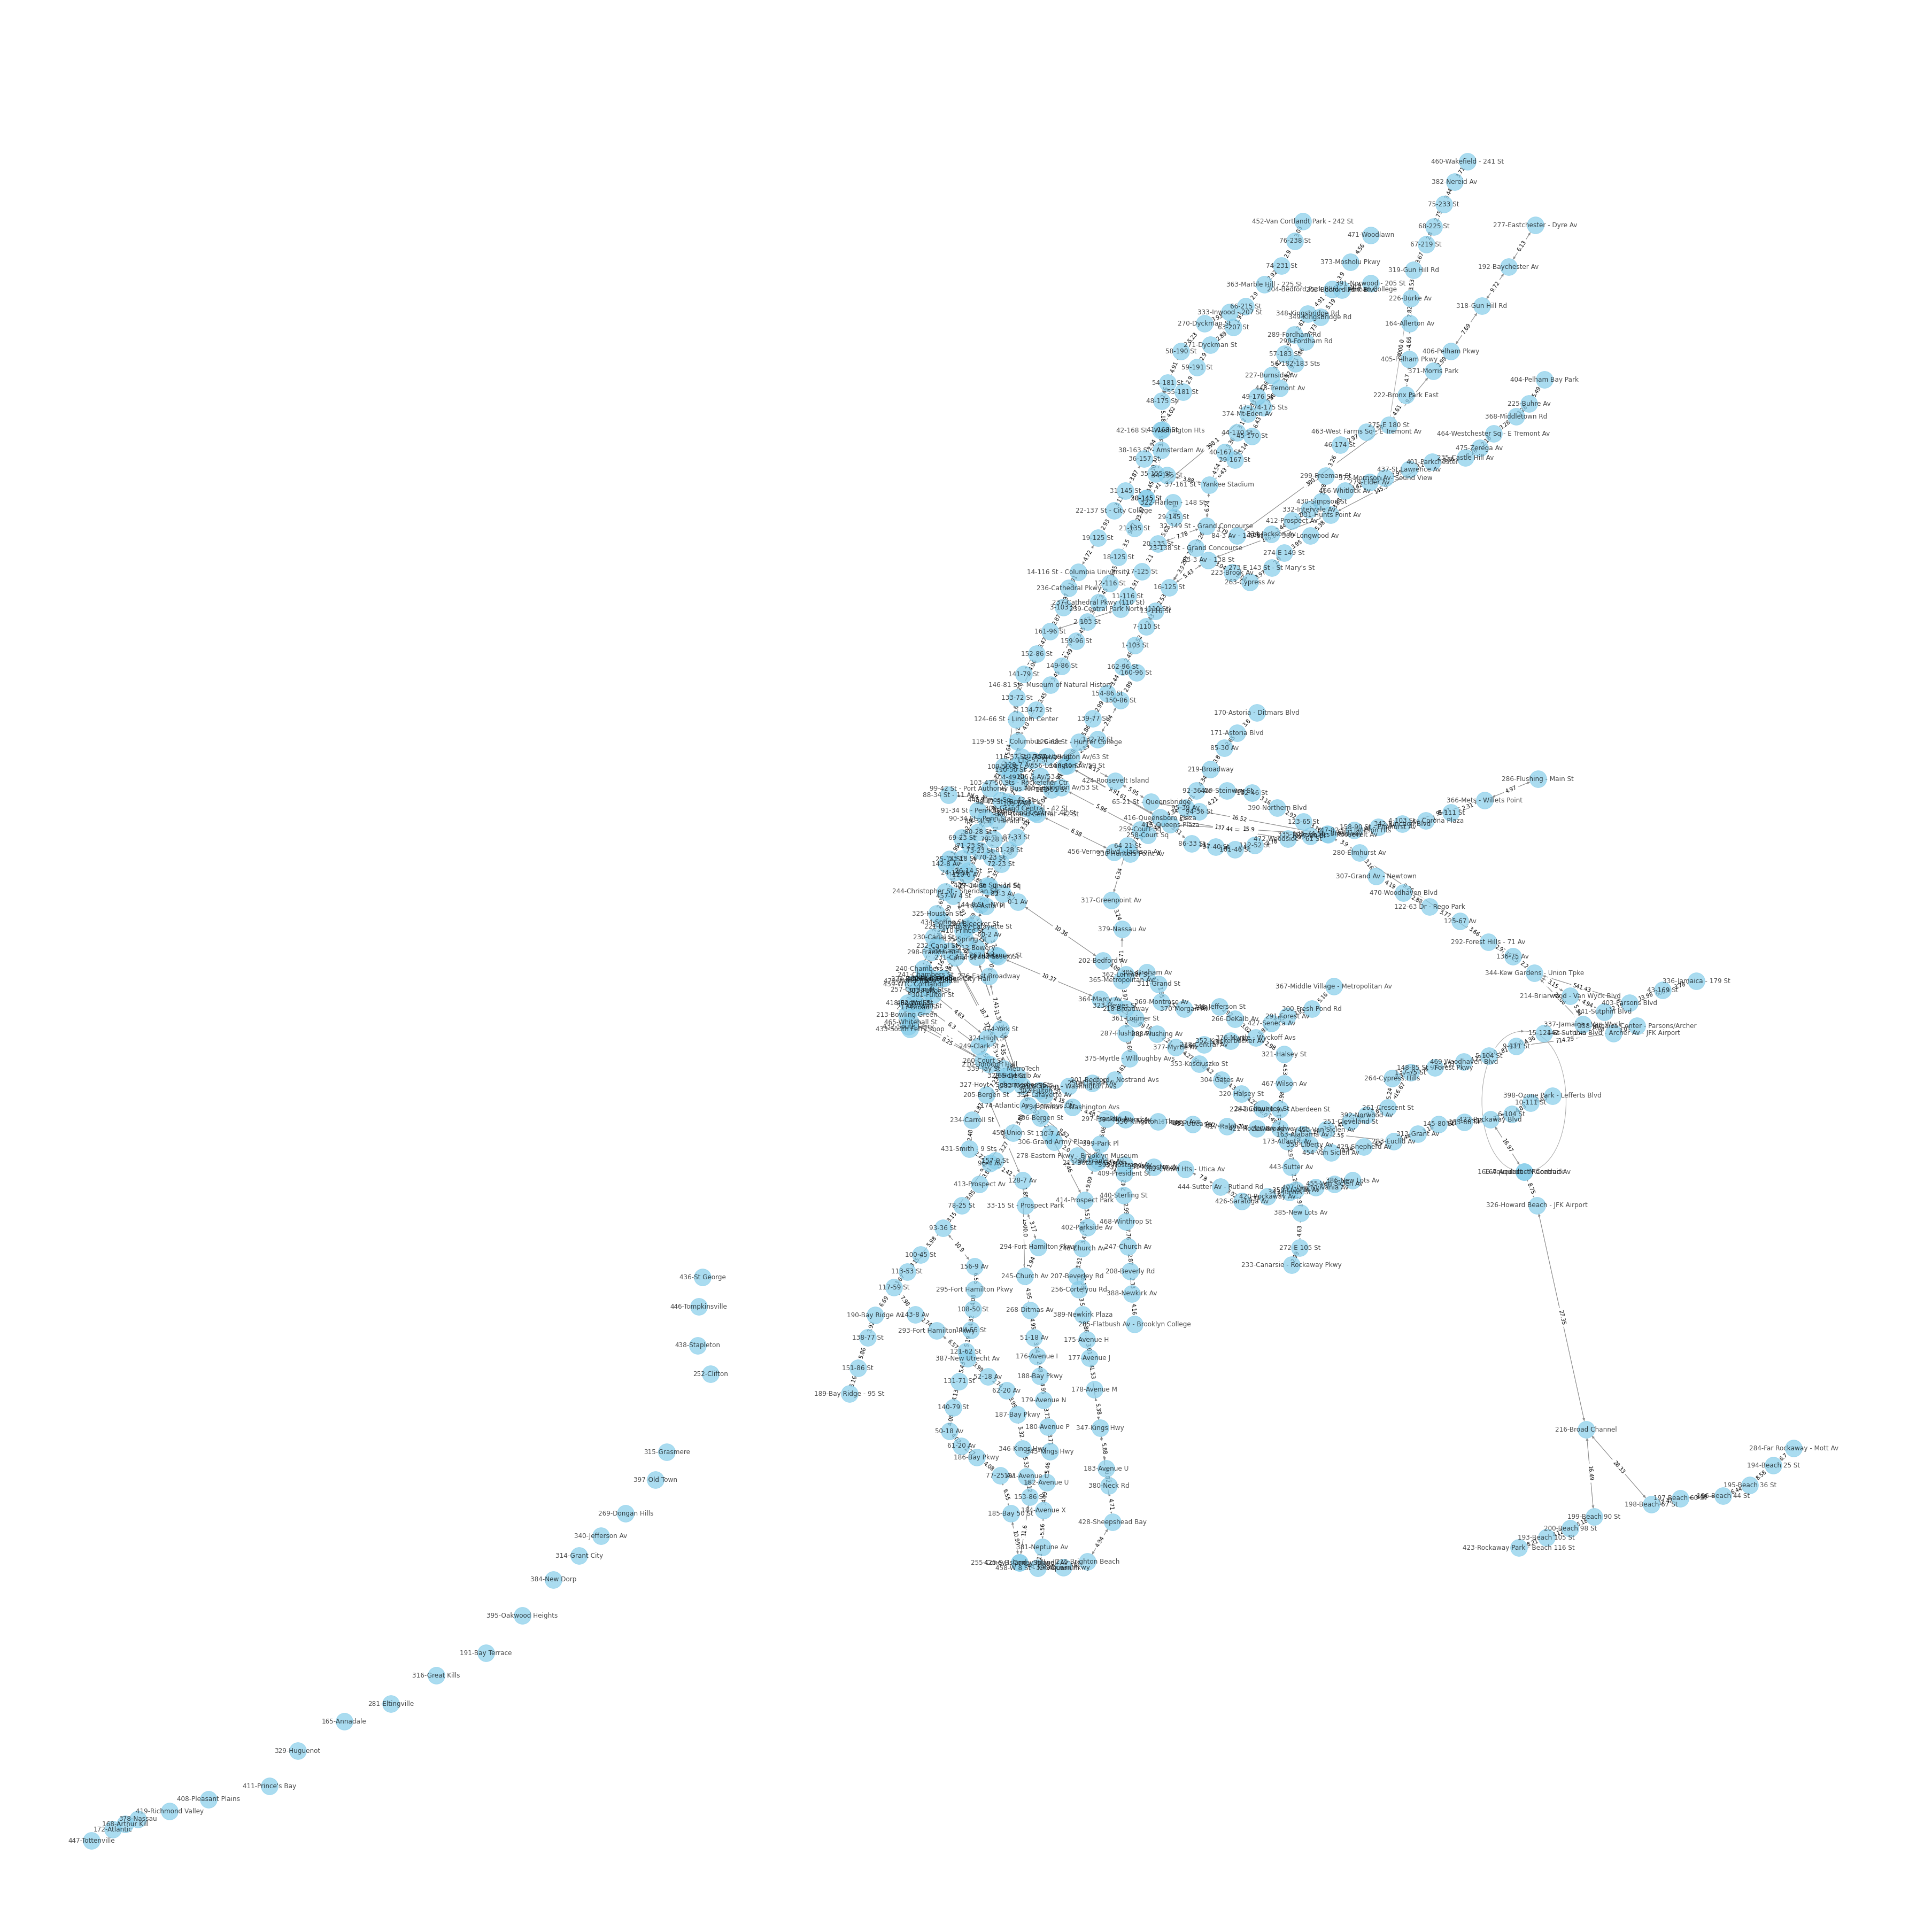

In [273]:
# nx.draw(G)

# Draw the graph using matplotlib
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(50,50)) 
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1000, alpha=0.7)
nx.draw_networkx_edge_labels(G, pos,
                        edge_labels=nx.get_edge_attributes(G,'weight'))
plt.show()

In [276]:
degrees = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
df = pd.DataFrame([degrees,closeness,betweenness]).transpose()
df.columns = ['degrees','closeness','betweenness']
df

,degrees,closeness,betweenness
0-1 Av,0.008421,0.044357,0.015847
1-103 St,0.008421,0.079537,0.001472
2-103 St,0.008421,0.072355,0.000831
3-103 St,0.008421,0.088045,0.061683
4-103 St - Corona Plaza,0.008421,0.066116,0.001985
...,...,...,...
471-Woodlawn,0.004211,0.049763,0.000000
472-Woodside - 61 St,0.016842,0.076620,0.041155
473-World Trade Center,0.004211,0.091269,0.000000
474-York St,0.008421,0.096605,0.003547
